In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8428575950130540280
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7802454016
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8225173738401789234
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:07:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Num GPUs Available:  1


In [2]:
from tensorflow.keras.layers import (Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Dropout, Flatten)
import matplotlib.pyplot as plt
import os
from datetime import datetime
import os
from glob import glob
from IPython import display
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import PIL
from PIL import Image
import random
from scipy import ndarray
import skimage as sk
from skimage import io
from skimage import util
from skimage import transform
import tensorflow as tf
from tensorflow.keras import layers
import time
import tensorflow_datasets as tfds

In [3]:
#Set the parameters
EPOCHS = 5000
IMAGE_SIZE = 256
SAVE_EVER_X_EPOCH = 100
DATASET_FOLDER = 'lego/'
num_examples_to_generate = 16
NOISE_SIZE = 100
fig_x = 16
fig_y = 16
BATCH_SIZE = 64
CHECKPOINTS = 1000

In [4]:
input_images = np.asarray([np.asarray(
    Image.open(file)
    .resize((IMAGE_SIZE, IMAGE_SIZE))
    ) for file in glob(DATASET_FOLDER+'*.png')])
print ("Input: " + str(input_images.shape))

np.random.shuffle(input_images)

train_images = input_images.reshape(input_images.shape[0], 256, 256, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5 

BUFFER_SIZE = input_images.shape[0]
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Input: (800, 256, 256, 3)


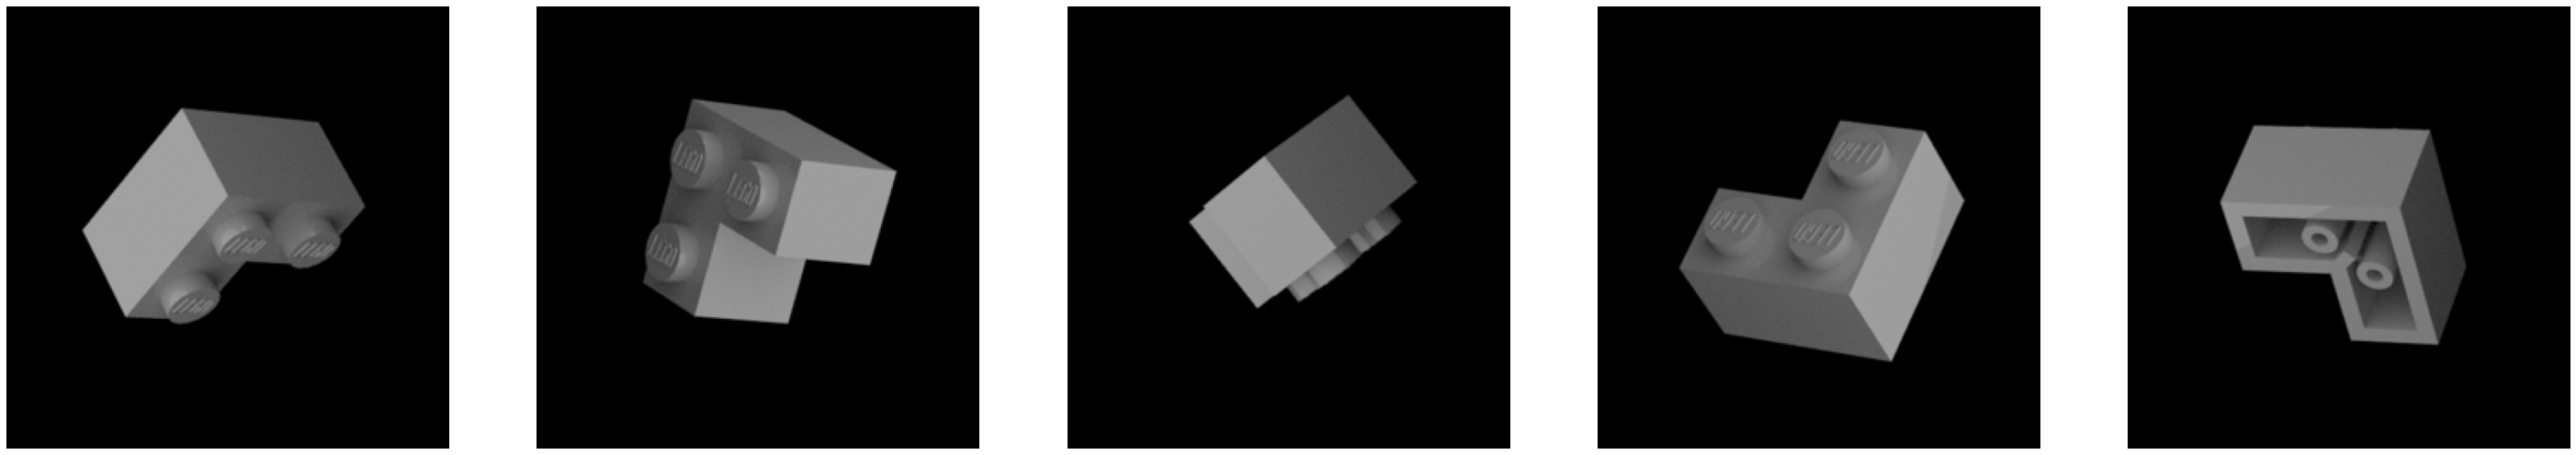

In [5]:
#Showing samples
sample_images = input_images[:5]
figure, axes = plt.subplots(1, len(sample_images), figsize = (50, 50))
for index, axis in enumerate(axes):
    axis.axis('off')
    image_array = sample_images[index]
    axis.imshow(image_array)
plt.show()
plt.close()

In [6]:
#Generator Network
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(NOISE_SIZE,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 512)))
    assert model.output_shape == (None, 8, 8, 512) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 256, 256, 3)

    return model

In [7]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3276800   
                                                                 
 batch_normalization (BatchN  (None, 32768)            131072    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        3276800   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 256)        1

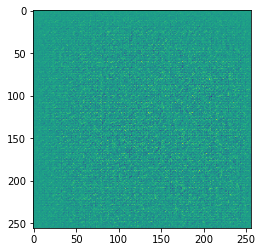

In [8]:
# Create a random noise and generate a sample
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0])

In [9]:
#Discriminator Network
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same', input_shape=[256, 256, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [10]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      1216      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 128, 128, 16)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        12832     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)       

In [11]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-7.957086e-05]], shape=(1, 1), dtype=float32)


In [12]:
#Configure the Model
#Loss Functions and Optimizers
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [13]:
#Set the Checkpoints
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [14]:
#Prep - Train the Model
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, NOISE_SIZE])

In [15]:
#Define the Training Step
# tf.function annotation causes the function 
# to be "compiled" as part of the training
@tf.function
def train_step(images):
  
    # 1 - Create a random noise to feed it into the model
    # for the image generation
    noise = tf.random.normal([BATCH_SIZE, NOISE_SIZE])
    
    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      
      #real_output = discriminator(tf.reshape(images, (1, 256, 256, 3)).astype('float32'), training=True)
      #real_output = discriminator(tf.reshape(images, (1, 256, 256, 3)), training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using 
    # operations recorded in context of this tape (gen_tape and disc_tape).
    
    # It accepts a target (e.g., gen_loss) variable and 
    # a source variable (e.g.,generator.trainable_variables)
    # target --> a list or nested structure of Tensors or Variables to be differentiated.
    # source --> a list or nested structure of Tensors or Variables.
    # target will be differentiated against elements in sources.

    # "gradient" method returns a list or nested structure of Tensors  
    # (or IndexedSlices, or None), one for each element in sources. 
    # Returned structure is the same as the structure of sources.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # 4 - Process  Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregated gradients. 
    # ex: optimizer.apply_gradients(zip(grads, vars))
    """
    Example use of apply_gradients:
    grads = tape.gradient(loss, vars)
    grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
    # Processing aggregated gradients.
    optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
    """
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return disc_loss, gen_loss

In [16]:
#Define the Training Loop
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs):
    trueStart = time.time()
    disc_loss = []
    gen_loss = []
    # A. For each epoch, do the following:
    for epoch in range(epochs):
        start = time.time()
    # 1 - For each batch of the epoch, 
        for image_batch in dataset:
          # 1.a - run the custom "train_step" function
          # we just declared above
            disc, gen = train_step(image_batch)
            disc_loss.append(disc)
            gen_loss.append(gen)

        # 2 - Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch + 1,seed)
        draw_epoch_graph(epoch, disc_loss, gen_loss)

        # 3 - Save the model every 5 epochs as 
        # a checkpoint, which we will use later
        if (epoch + 1) % CHECKPOINTS == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        # 4 - Print out the completed epoch no. and the time spent
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # B. Generate a final image after the training is completed
    display.clear_output(wait=True)
    #generate_and_save_images2(generator,epochs,seed)
    draw_epoch_graph2(epoch, disc_loss, gen_loss)
    print ('Total Time for {} epochs is {} sec'.format(epoch + 1, time.time()-trueStart))

In [17]:
#Image Generation Function
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    # 1 - Generate images
    predictions = model(test_input, training=False)
    # 2 - Plot the generated images
    fig = plt.figure(figsize=(fig_x,fig_y))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        genImage = predictions[i].numpy() * 127.5 + 127.5
        plt.imshow(genImage.astype('uint8'))
        plt.axis('off')
    if (epoch + 1) % SAVE_EVER_X_EPOCH == 0:
        plt.savefig('epochImages/image_at_epoch_{:04d}.png'.format(epoch+1))
    plt.show()

#Image Generation Function
def generate_and_save_images2(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    # 1 - Generate images
    predictions = model(test_input, training=False)
    # 2 - Plot the generated images
    fig = plt.figure(figsize=(fig_x,fig_y))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        genImage = predictions[i].numpy() * 127.5 + 127.5
        plt.imshow(genImage.astype('uint8'))
        plt.axis('off')
    # 3 - Save the generated images
    plt.savefig('epochImages/image_at_epoch_{:04d}.png'.format(epoch+1))
    plt.show()

In [18]:
#Generate a graph over time for measure losses and wins for Generator and Discriminator
def draw_epoch_graph(epoch, disc_loss, gen_loss):
    fig, ax = plt.subplots()
    #fig = plt.figure(figsize=(10,10))
    plt.plot(disc_loss, label='Discriminator', alpha=0.6)
    plt.plot(gen_loss, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.show()
    plt.close()

def draw_epoch_graph2(epoch, disc_loss, gen_loss):
    fig, ax = plt.subplots()
    fig = plt.figure(figsize=(fig_x,fig_y))
    plt.plot(disc_loss, label='Discriminator', alpha=0.6)
    plt.plot(gen_loss, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.savefig('epochImages/results_graph_epoch_' + str(epoch+1) + '.png')
    plt.show()
    plt.close()

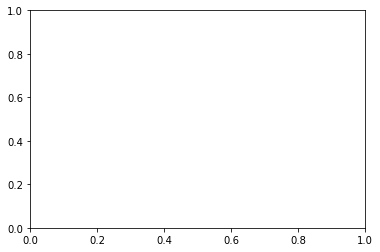

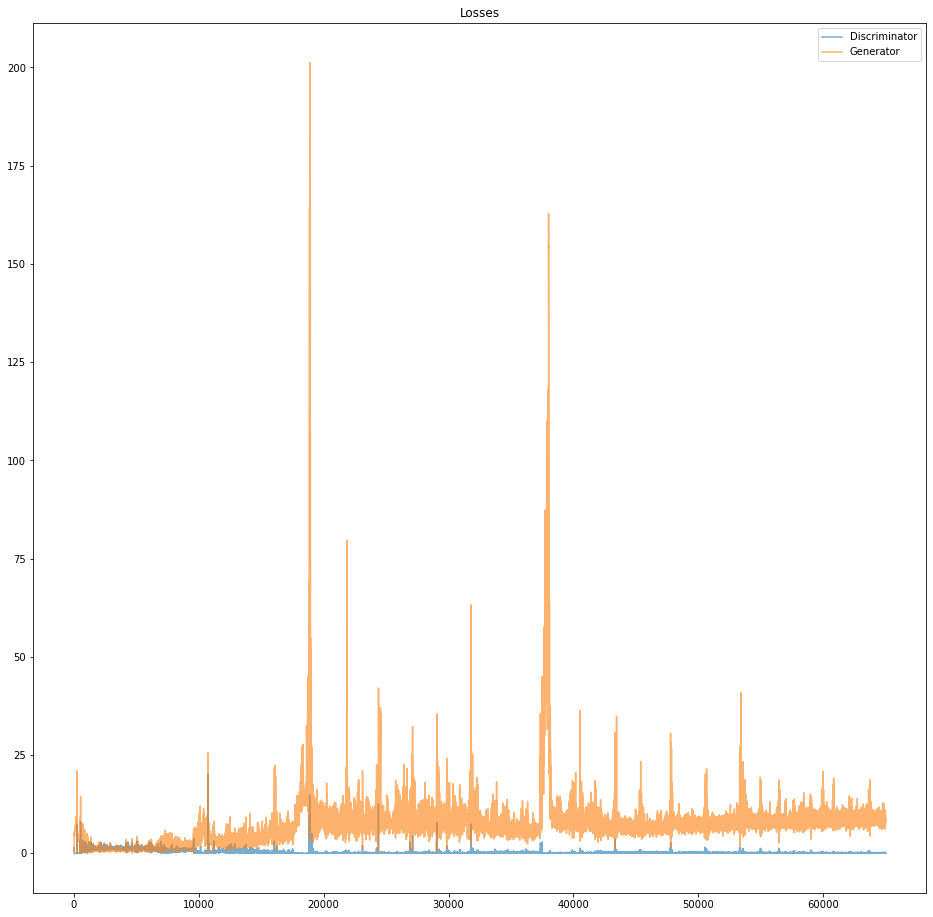

Total Time for 5000 epochs is 13771.71935248375 sec


In [19]:
#Start the Training
train(train_dataset, EPOCHS)

In [20]:
#Generate Digits
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

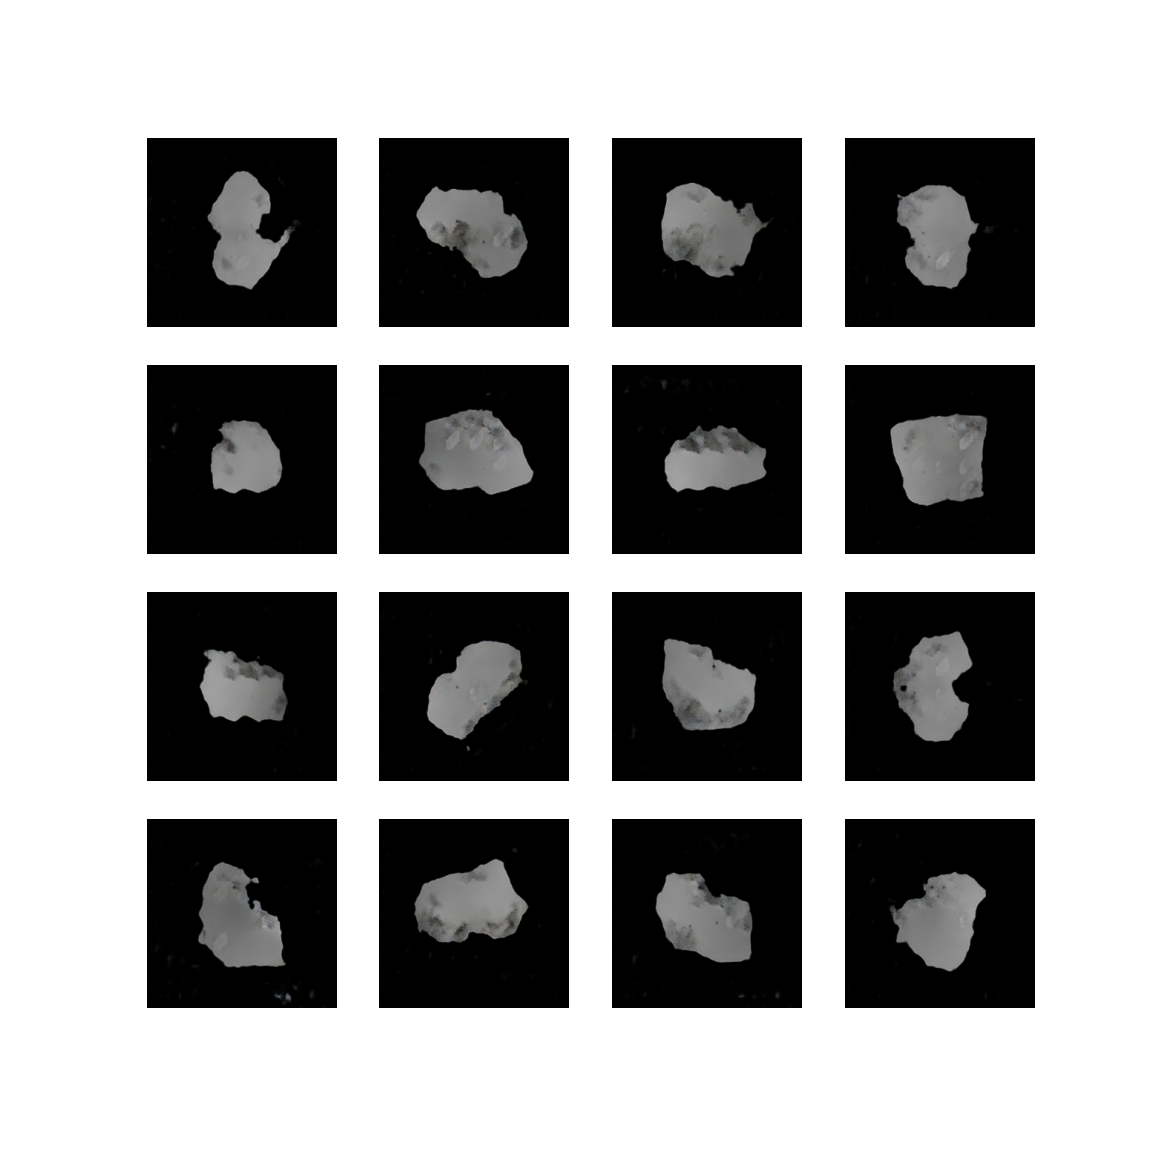

In [21]:
#View any 4x4 grid generations of any epoch
# PIL is a library which may open different image file formats
import PIL 
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('epochImages/image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)